In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Health Care 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care
1411,1998-12-02,1171.25,362.970001,-12.300735,5.327767,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1412,1998-12-03,1150.14,352.160004,-12.040563,4.495414,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1413,1998-12-04,1176.74,360.369995,-10.207476,6.646738,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1414,1998-12-07,1187.70,360.679993,-7.240649,9.151432,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
1415,1998-12-08,1181.38,361.799988,-7.513935,11.429359,OUTPERFORM,164.700,246.500,226.200,251.200,159.000
...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1541.250000,19.548197,4.350034,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7195,2021-11-26,4594.62,1534.349976,16.437110,3.875838,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7196,2021-11-29,4655.27,1540.150024,19.324593,3.702631,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561
7197,2021-11-30,4567.00,1510.449951,17.908879,1.978877,UNDERPERFORM,280.126,531.268,379.611,580.198,247.561


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,2010,1,2010-01-14,1148.46,376.410004,-2.941027,4.268699,OUTPERFORM,217.281,384.308,311.761,406.672,206.214,3
134,2010,2,2010-02-11,1078.47,358.869995,-9.326551,1.473164,OUTPERFORM,217.353,385.712,312.658,408.261,206.263,3
135,2010,3,2010-03-11,1150.24,370.440002,-8.476491,0.975854,OUTPERFORM,217.403,386.589,313.219,409.253,206.024,3
136,2010,4,2010-04-08,1186.44,370.679993,-7.551331,-0.582007,OUTPERFORM,217.290,387.094,314.192,409.547,206.180,3
137,2010,5,2010-05-13,1157.44,351.940002,-12.792152,-6.543095,OUTPERFORM,217.199,388.188,314.995,410.740,206.407,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,1.147999,-3.942885,UNDERPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,7.276877,-0.738775,UNDERPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,15.209058,3.386882,UNDERPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,8.483351,-2.675431,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [4]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [5]:
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
133,1,1148.46,376.410004,-2.941027,4.268699,217.281,384.308,311.761,406.672,206.214,3
134,2,1078.47,358.869995,-9.326551,1.473164,217.353,385.712,312.658,408.261,206.263,3
135,3,1150.24,370.440002,-8.476491,0.975854,217.403,386.589,313.219,409.253,206.024,3
136,4,1186.44,370.679993,-7.551331,-0.582007,217.290,387.094,314.192,409.547,206.180,3
137,5,1157.44,351.940002,-12.792152,-6.543095,217.199,388.188,314.995,410.740,206.407,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,7
Size in Memory,8.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.46,0.50,2,77
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
medical Care,float64,0,0,384.31,454.19,531.27,456.94,43.33,143,1
medical care commodities,float64,0,0,311.76,357.41,387.53,356.34,23.83,143,1
medical care services,float64,0,0,406.67,485.35,580.20,489.052,50.36,143,1
personal Care,float64,0,0,206.024,222.37,247.56,223.40,11.35,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

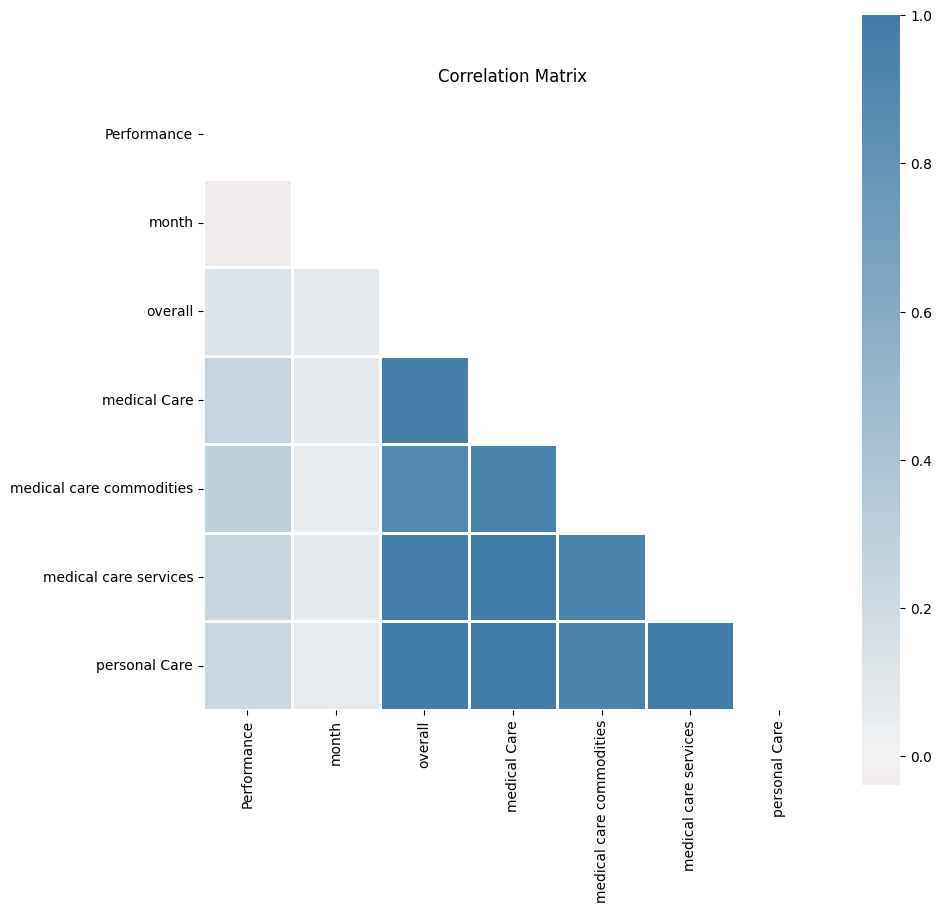

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,8,3420.100343,959.708154,5.320253,-3.276076,249.581416,467.203212,382.034769,517.131398,236.502478,3
1,10,3841.752324,1676.085265,-29.159443,-23.844090,290.309718,577.328391,388.547659,633.725467,249.610954,3
2,2,1264.632952,369.782883,-10.343490,-20.409720,229.050727,431.549343,328.856772,412.437796,213.879450,3
3,6,1518.197958,380.656735,-11.433992,-13.114130,232.400743,434.003849,343.086955,447.680833,210.257471,3
4,11,2430.531751,801.503901,-2.460939,-12.810655,241.032246,501.438914,388.383689,512.695679,234.275466,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,3,3244.575062,871.405198,-15.135577,-18.493879,253.093836,449.541405,375.200860,540.125454,230.822765,3
9996,2,3930.405818,1257.685879,2.314720,-0.296979,263.606537,476.205598,388.161758,481.335639,232.953954,3
9997,9,2366.165120,1034.795592,6.959835,-1.762787,248.360610,455.537996,378.455922,505.760787,232.152343,3
9998,3,3558.161218,1009.358597,-6.161500,-4.337272,256.602104,496.623956,382.901948,550.745731,239.335640,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
samples.head()

,Performance,month,overall,medical Care,medical care commodities,medical care services,personal Care
0,0,8,249.581416,467.203212,382.034769,517.131398,236.502478
1,1,10,290.309718,577.328391,388.547659,633.725467,249.610954
2,0,2,229.050727,431.549343,328.856772,412.437796,213.879450
3,0,6,232.400743,434.003849,343.086955,447.680833,210.257471
4,0,11,241.032246,501.438914,388.383689,512.695679,234.275466


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.36,0.48,2,6427
month,int64,0,0,1,6,12,6.48,3.43,12,879
overall,float64,0,0,205.95,239.96,291.78,243.96,16.90,10000,1
medical Care,float64,0,0,363.016,467.18,580.60,461.46,46.25,10000,1
medical care commodities,float64,0,0,288.25,362.67,410.023,357.89,25.27,10000,1
medical care services,float64,0,0,365.33,488.050,633.82,490.96,55.42,10000,1
personal Care,float64,0,0,192.78,223.64,254.78,223.66,11.97,9999,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

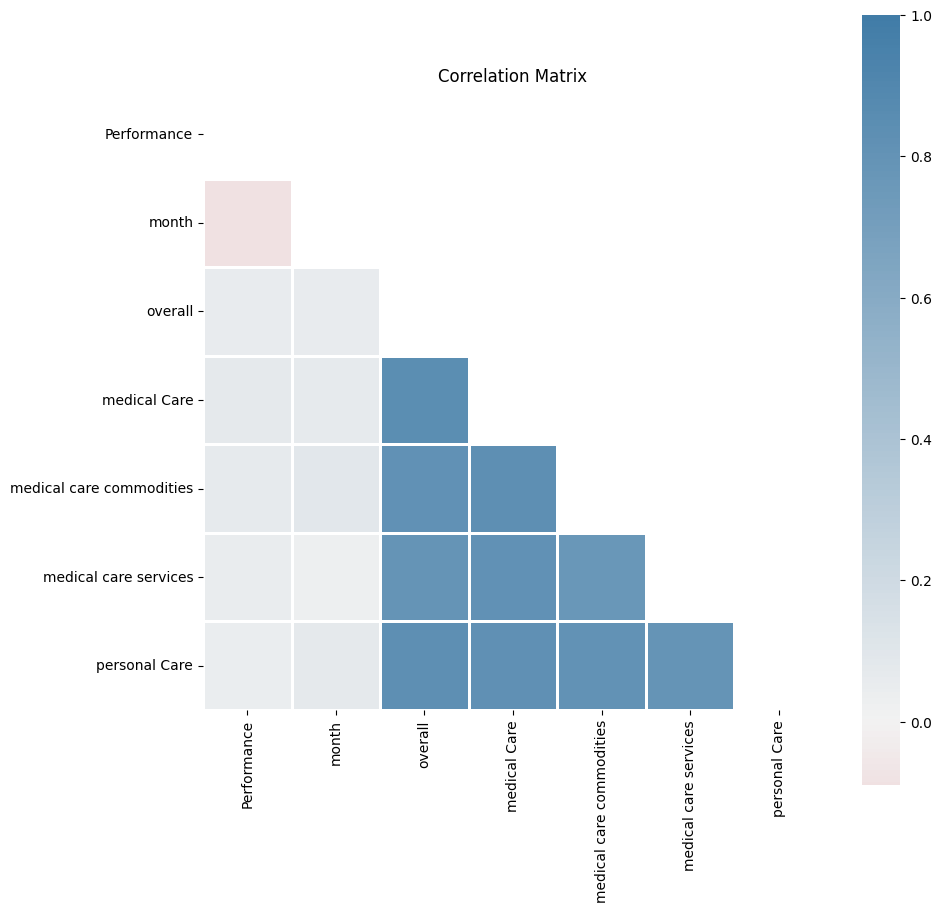

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6427, 1: 3573})
Counter({0: 6427, 1: 6427})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[2.49581416e+02, 4.67203212e+02, 3.82034769e+02, ...,
        1.97562174e+05, 9.03521696e+04, 1.22302857e+05],
       [2.90309718e+02, 5.77328391e+02, 3.88547659e+02, ...,
        2.46232547e+05, 9.69857517e+04, 1.58184818e+05],
       [2.29050727e+02, 4.31549343e+02, 3.28856772e+02, ...,
        1.35632962e+05, 7.03357056e+04, 8.82119690e+04],
       ...,
       [2.25908336e+02, 4.38771556e+02, 3.18710648e+02, ...,
        1.40742776e+05, 6.69506225e+04, 9.27657338e+04],
       [2.12155675e+02, 3.98162989e+02, 3.05134146e+02, ...,
        1.26617118e+05, 6.20144044e+04, 8.43341325e+04],
       [2.57170270e+02, 4.71808926e+02, 3.70119625e+02, ...,
        1.94791537e+05, 8.59220617e+04, 1.22177307e+05]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12854, 16)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 16)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.658716,0.637227,0.729888,0.679409,0.645302,0.62322,0.715723,0.666276,0.643357,0.594937,0.712121,0.648276
1,DecisionTreeClassifier,0.6416,0.631685,0.67341,0.650824,0.630678,0.620442,0.65283,0.636224,0.566434,0.532258,0.5,0.515625
2,RandomForestClassifier,0.720026,0.705634,0.746853,0.723188,0.717486,0.707421,0.731447,0.719233,0.657343,0.644068,0.575758,0.608
3,AdaBoostClassifier,0.615687,0.615444,0.616312,0.615646,0.609521,0.608555,0.590566,0.599425,0.643357,0.619048,0.590909,0.604651
4,GradientBoostingClassifier,0.63646,0.62807,0.667654,0.646985,0.640012,0.626239,0.675472,0.649924,0.657343,0.616438,0.681818,0.647482
5,ExtraTreesClassifier,0.747646,0.735037,0.767087,0.747125,0.734287,0.72276,0.750943,0.736582,0.608392,0.575758,0.575758,0.575758
6,BaggingClassifier,0.689682,0.698616,0.660185,0.676615,0.666148,0.671079,0.637736,0.653983,0.664336,0.666667,0.545455,0.6
7,SVC,0.62121,0.609639,0.672942,0.639577,0.61201,0.59662,0.666038,0.629421,0.713287,0.658228,0.787879,0.717241
8,GaussianNB,0.560058,0.574991,0.461017,0.511571,0.540448,0.543969,0.439623,0.486261,0.587413,0.574468,0.409091,0.477876


## Using all data 

In [21]:
data = pd.read_csv('../data/S&P 500 Health Care 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),S&P 500 Health Care (Sector) Outperform/Underperform,overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,1998,12,1998-12-10,1165.02,353.089996,-9.138980,9.976328,OUTPERFORM,164.700,246.500,226.200,251.200,159.000,3
1,1999,1,1999-01-14,1212.19,348.149994,-11.059996,-2.443467,OUTPERFORM,164.700,247.300,226.900,252.000,159.400,3
2,1999,2,1999-02-11,1254.04,365.540009,-11.476613,0.624885,OUTPERFORM,164.800,247.900,227.600,252.500,159.900,3
3,1999,3,1999-03-11,1297.68,384.720001,-11.016635,15.486445,OUTPERFORM,165.900,248.700,229.000,253.100,160.000,3
4,1999,4,1999-04-08,1343.98,390.510010,-6.756119,14.277774,OUTPERFORM,166.000,249.300,229.200,253.900,160.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1496.079956,1.147999,-3.942885,UNDERPERFORM,273.092,524.845,375.685,572.969,244.968,3
272,2021,8,2021-08-12,4460.83,1547.819946,7.276877,-0.738775,UNDERPERFORM,274.214,525.861,376.842,573.939,244.840,3
273,2021,9,2021-09-09,4493.28,1563.829956,15.209058,3.386882,UNDERPERFORM,276.590,528.134,379.003,576.248,246.307,3
274,2021,10,2021-10-14,4438.26,1484.189941,8.483351,-2.675431,UNDERPERFORM,278.524,529.754,379.483,578.237,246.445,3


In [22]:
original = data[['S&P 500 Health Care (Sector) Outperform/Underperform','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
data.drop(columns=['date','S&P 500 Health Care (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Health Care (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Health Care (Sector),S&P 500 Performance (%),S&P 500 Health Care (Sector) Performance (%),overall,medical Care,medical care commodities,medical care services,personal Care,dow
0,7,1160.741816,364.440369,-29.924996,-14.591378,167.714013,332.632297,261.041122,300.886545,179.611394,3
1,6,4874.205494,1528.527267,-9.878482,-9.569751,249.349894,510.710673,359.626447,509.657870,227.310315,3
2,11,4294.486414,1081.214047,-0.768613,-3.887485,278.404635,536.407066,382.633635,557.996558,235.063048,3
3,1,885.446680,380.185568,-14.642397,-17.136107,215.412347,415.736823,334.111220,400.529240,209.321232,3
4,11,952.096667,374.625509,-9.153063,-6.355286,232.117147,408.239184,326.351174,438.964547,212.649911,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2470.518283,1037.377023,-7.282836,-7.274671,256.993399,479.985188,384.999668,484.186775,233.229233,3
9996,12,1290.795129,377.309328,12.176256,-3.729796,183.731496,289.575194,240.375619,280.452285,178.896054,3
9997,1,3349.487951,1431.358989,30.579346,31.934659,281.829384,548.126941,391.472402,578.688393,247.128799,3
9998,9,1398.972982,400.095239,-9.492212,-2.720069,224.202422,359.429666,344.780640,288.657098,207.598414,3


In [23]:
samples['Performance'] = np.where(samples['S&P 500 Health Care (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','medical Care',\
                 'medical care commodities','medical care services','personal Care']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.590336,0.585694,0.612196,0.598215,0.577331,0.572448,0.59014,0.581159,0.547101,0.5625,0.453237,0.501992
1,DecisionTreeClassifier,0.577448,0.573354,0.59173,0.581128,0.58574,0.581295,0.594555,0.58785,0.597826,0.59589,0.625899,0.610526
2,RandomForestClassifier,0.640173,0.636178,0.64039,0.635562,0.618647,0.619335,0.603385,0.611256,0.48913,0.489583,0.338129,0.4
3,AdaBoostClassifier,0.614374,0.629317,0.556604,0.590479,0.593053,0.599354,0.54599,0.571429,0.57971,0.598291,0.503597,0.546875
4,GradientBoostingClassifier,0.619128,0.632877,0.567941,0.598401,0.618282,0.624309,0.582046,0.602437,0.557971,0.57265,0.482014,0.523438
5,ExtraTreesClassifier,0.64511,0.6431,0.639474,0.638039,0.628519,0.625274,0.629875,0.627566,0.532609,0.552083,0.381295,0.451064
6,BaggingClassifier,0.615668,0.63014,0.547127,0.583475,0.606581,0.621044,0.534216,0.574367,0.536232,0.566265,0.338129,0.423423
7,SVC,0.60267,0.609169,0.572689,0.590182,0.591225,0.591775,0.571744,0.581587,0.568841,0.580645,0.517986,0.547529
8,GaussianNB,0.590053,0.609469,0.501191,0.549937,0.580622,0.592496,0.499632,0.542116,0.550725,0.570093,0.438849,0.495935


### Voting Classifier

In [24]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.634004,0.630466,0.636497,0.633468
